<a href="https://colab.research.google.com/github/Boliang312/Deep-Learning/blob/main/Midterm_Chen_Boliang.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install kaggle


In [3]:
from google.colab import files
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [4]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [5]:
!kaggle competitions download -c dogs-vs-cats

 99% 802M/812M [00:03<00:00, 235MB/s]
100% 812M/812M [00:03<00:00, 252MB/s]


In [6]:
#import os libs
import os
import shutil
import itertools
import pathlib
from PIL import Image
#import Data handling
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
from sklearn.metrics import confusion_matrix , classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
#import Deep learning tools
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D , MaxPooling2D , Dense , BatchNormalization , Dropout,Flatten , Activation
from tensorflow.keras.optimizers import Adam , Adamax
from tensorflow.keras import regularizers

#Warnings
import warnings
warnings.filterwarnings('ignore')

In [7]:
!unzip dogs-vs-cats.zip


Archive:  dogs-vs-cats.zip
  inflating: sampleSubmission.csv    
  inflating: test1.zip               
  inflating: train.zip               


In [ ]:
!unzip test1.zip
!unzip train.zip

In [9]:
import os

working_dir = os.getcwd()  # Get the current working directory
new_directory_path = os.path.join(working_dir, 'working')

if not os.path.exists(new_directory_path):
    os.makedirs(new_directory_path)

In [11]:
path , dirs , files = next(os.walk('working/train'))
file_count = len(files)
print(file_count)
base_dir = 'working/dogs_vs_cats_small'
os.mkdir(base_dir)

25000


In [12]:
train_dir = os.path.join(base_dir , 'train')
os.mkdir(train_dir) #make a new train directory inside my base directory

valid_dir= os.path.join(base_dir , 'validation')
os.mkdir(valid_dir) #make a new validation directory inside my base directory

test_dir = os.path.join(base_dir , 'test')
os.mkdir(test_dir) #make a new test directory inside my base directory

train_cats_dir = os.path.join(train_dir , 'cats')
os.mkdir(train_cats_dir) #make a new cats directory inside my train directory

train_dogs_dir = os.path.join(train_dir , 'dogs')
os.mkdir(train_dogs_dir) #make a new dogs directory inside my train directory

valid_cats_dir = os.path.join(valid_dir, 'cats')
os.mkdir(valid_cats_dir) #make a new cats directory inside my validation directory

valid_dogs_dir = os.path.join(valid_dir , 'dogs')
os.mkdir(valid_dogs_dir) #make a new dogs directory inside my validation directory

test_cats_dir = os.path.join(test_dir , 'cats')
os.mkdir(test_cats_dir) #make a new cats directory inside my test directory

test_dogs_dir = os.path.join(test_dir , 'dogs')
os.mkdir(test_dogs_dir) #make a new dogs directory inside my test directory

In [13]:
dir_path = 'working/train'

cat_count = 0
dog_count= 0
for i in os.listdir(dir_path):
    if i.startswith('cat.'):
        cat_count += 1
    elif i.startswith('dog.'):
        dog_count += 1

print(f"Number of cat images: {cat_count}")
print(f"Number of dog images: {dog_count}")

Number of cat images: 12500
Number of dog images: 12500


In [14]:
original_dataset_dir = 'working/train'

fnames = ['cat.{}.jpg'.format(i) for i in range(10001)] #Move 10,000 cat images from the original dataset to the train cat directory
for fname in fnames:
  src = os.path.join(original_dataset_dir , fname)
  dst = os.path.join(train_cats_dir , fname)
  shutil.copyfile(src , dst)

fnames = ['cat.{}.jpg'.format(i) for i in range(10001,11251)] #Move 1250 cat images from the original dataset to the validation cat directory
for fname in fnames:
  src = os.path.join(original_dataset_dir , fname)
  dst = os.path.join(valid_cats_dir , fname)
  shutil.copyfile(src,dst)

fnames = ['cat.{}.jpg'.format(i) for i in range(11251,12500)] #Move 1250 cat images from the original dataset to the test cat directory
for fname in fnames:
  src= os.path.join(original_dataset_dir , fname)
  dst= os.path.join(test_cats_dir, fname)
  shutil.copyfile(src,dst)

fnames = ['dog.{}.jpg'.format(i) for i in range(10001)] #Move 10,000 dog images from the original dataset to the train cat directory
for fname in fnames:
  src = os.path.join(original_dataset_dir , fname)
  dst = os.path.join(train_dogs_dir ,fname)
  shutil.copyfile(src,dst)

fnames = ['dog.{}.jpg'.format(i) for i in range(10001,11251)] #Move 1250 dog images from the original dataset to the validation cat directory
for fname in fnames:
  src = os.path.join(original_dataset_dir,fname)
  dst = os.path.join(valid_dogs_dir , fname)
  shutil.copyfile(src,dst)

fnames = ['dog.{}.jpg'.format(i) for i in range(11251,12500)]#Move 1250 dog images from the original dataset to the test cat directory
for fname in fnames:
  src= os.path.join(original_dataset_dir, fname)
  dst = os.path.join(test_dogs_dir , fname)
  shutil.copyfile(src, dst)

In [15]:
print(f'Total training cat images {len(os.listdir(train_cats_dir))}')
print(f'Total validation cat images {len(os.listdir(valid_cats_dir))}')
print(f'Total test cat images {len(os.listdir(test_cats_dir))}')
print('\n')
print(f'Total training dog images {len(os.listdir(train_dogs_dir))}')
print(f'Total validation dog images {len(os.listdir(valid_dogs_dir))}')
print(f'Total test dog images {len(os.listdir(test_dogs_dir))}')

Total training cat images 10001
Total validation cat images 1250
Total test cat images 1249


Total training dog images 10001
Total validation dog images 1250
Total test dog images 1249


In [16]:
img_size = (224 , 224)
batch_size = 32
img_shape = (img_size[0] , img_size[1] , 3)

tr_gen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest' )
ts_gen = ImageDataGenerator()

train_gen = tr_gen.flow_from_directory(train_dir , target_size = img_size , class_mode = 'binary' ,
                                       color_mode = 'rgb' , shuffle = True , batch_size = batch_size)

valid_gen = ts_gen.flow_from_directory(valid_dir , target_size = img_size , class_mode = 'binary' ,
                                       color_mode = 'rgb' , shuffle = True , batch_size = batch_size)

test_gen = ts_gen.flow_from_directory(test_dir , target_size = img_size , class_mode = 'binary' ,
                                       color_mode = 'rgb' , shuffle = False , batch_size = batch_size)

Found 20002 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.
Found 2498 images belonging to 2 classes.


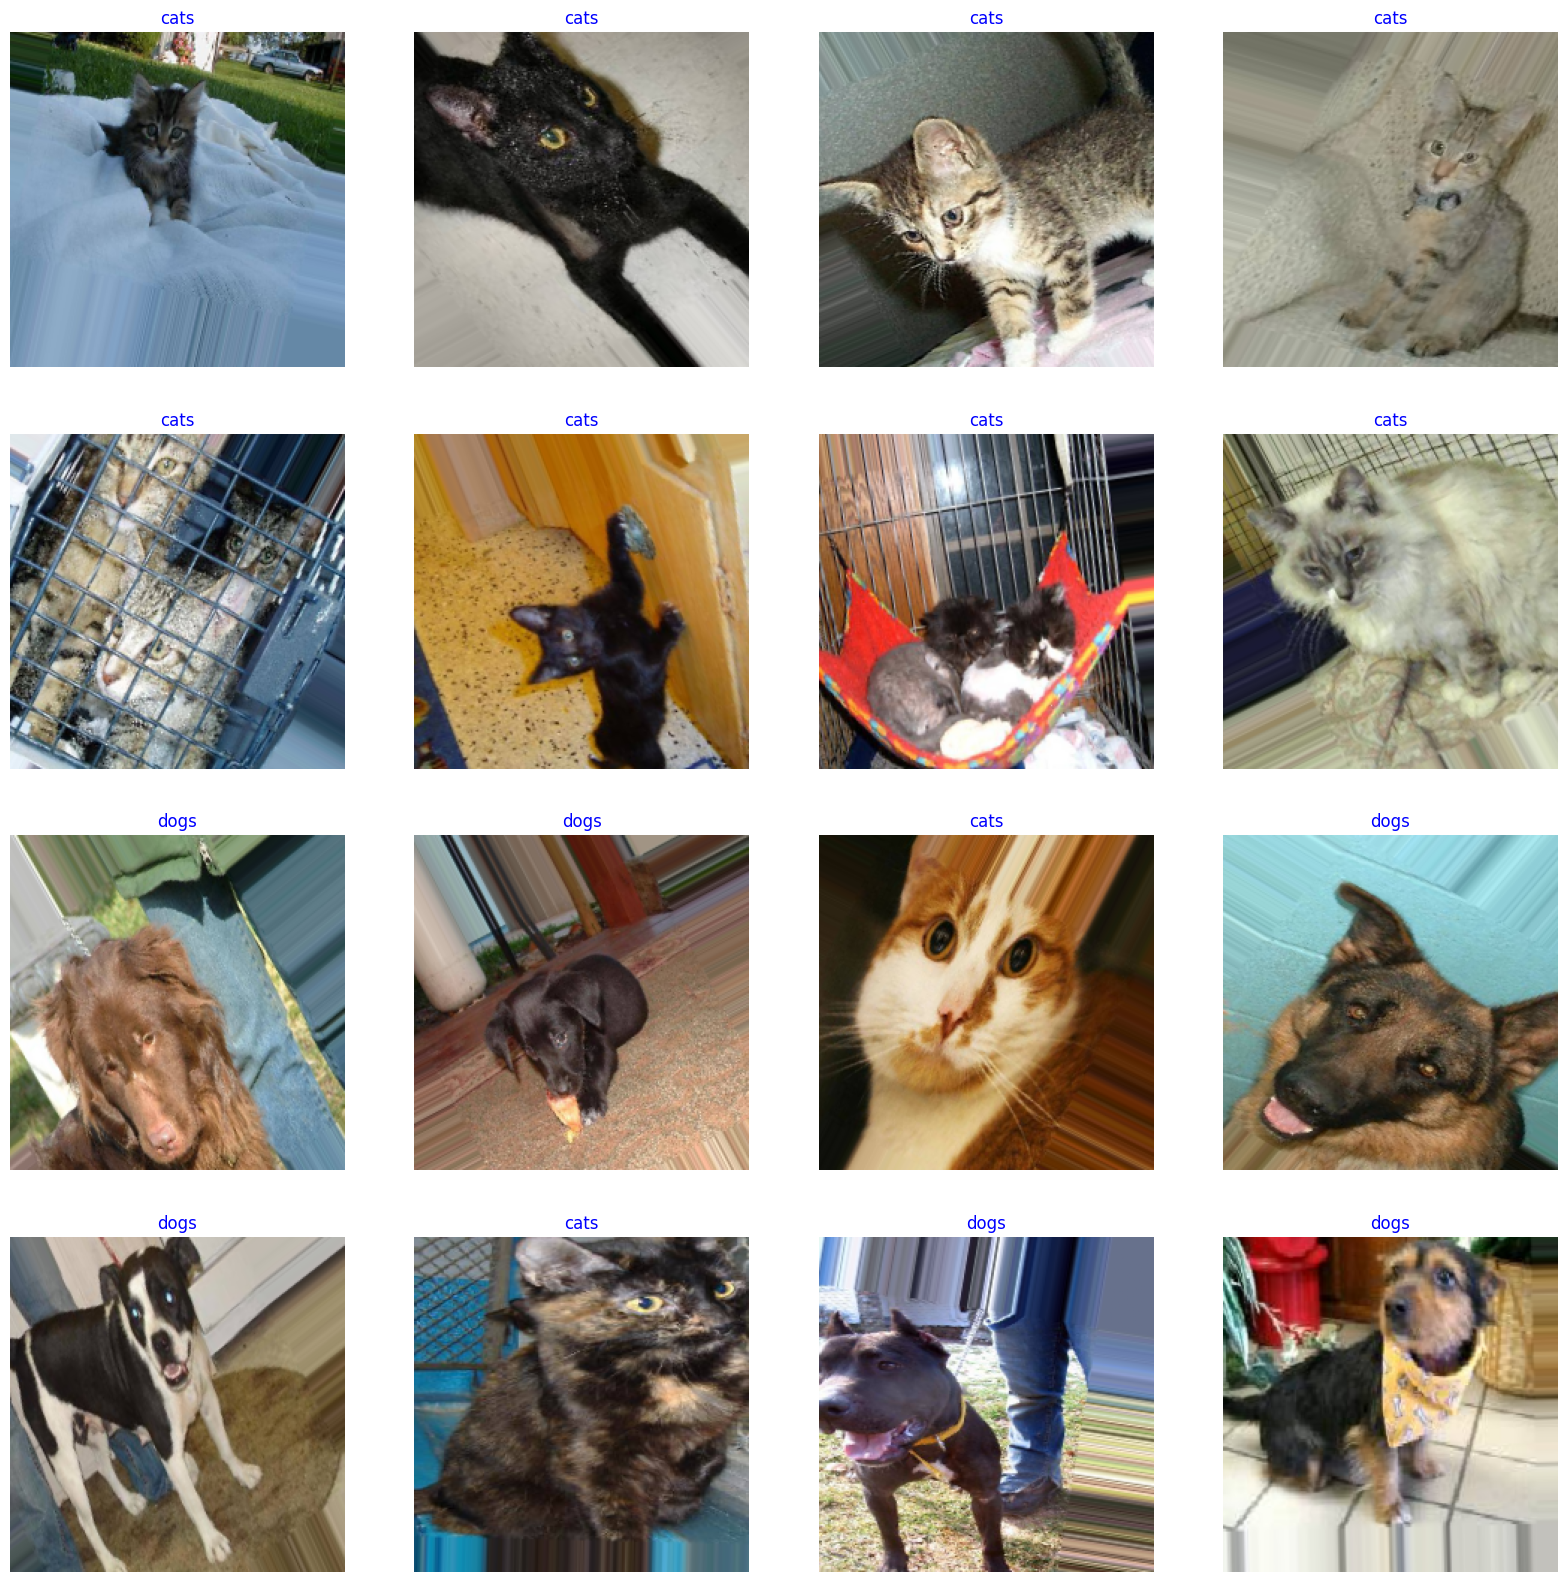

In [17]:
g_dict = train_gen.class_indices
classes = list(g_dict.keys())
images, labels = next(train_gen)
num_samples = len(images)

plt.figure(figsize=(20, 20))

for i in range(min(16, num_samples)):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255
    plt.imshow(image)
    class_index = int(labels[i])
    class_name = classes[class_index]
    plt.title(class_name, color='blue', fontsize=12)
    plt.axis('off')
plt.show()

In [18]:
img_shape = (img_size[0] , img_size[1] , 3)
base_model = tf.keras.applications.efficientnet.EfficientNetB5(include_top=False, weights='imagenet',
                                                               input_shape=img_shape, pooling='max')
base_model.trainable = False

model = Sequential([
    base_model,
    BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001),
    Dense(512, kernel_regularizer=regularizers.l2(l=0.016),
          activity_regularizer=regularizers.l1(0.006),
          bias_regularizer=regularizers.l1(0.006), activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(Adam(learning_rate=0.0005), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

115263384/115263384 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb5 (Functional  (None, 2048)              28513527  
 )                                                               
                                                                 
 batch_normalization (Batch  (None, 2048)              8192      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dense_1 (Dense)             (None, 1)                 513       
                                                                 
Total params: 29571320 (112.81 MB)
Trainable params: 1053697 (4.02 MB)
Non-trainable params: 28517623 (108.79 MB)
_______

In [19]:
history = model.fit(x=train_gen, validation_data=valid_gen, epochs=8, verbose=1, validation_steps=None, shuffle=False)

Epoch 1/8
626/626 [==============================] - 344s 512ms/step - loss: 1.6667 - accuracy: 0.9701 - val_loss: 0.2057 - val_accuracy: 0.9852
Epoch 2/8
626/626 [==============================] - 315s 503ms/step - loss: 0.1952 - accuracy: 0.9770 - val_loss: 0.1537 - val_accuracy: 0.9820
Epoch 3/8
626/626 [==============================] - 311s 497ms/step - loss: 0.1656 - accuracy: 0.9767 - val_loss: 0.1414 - val_accuracy: 0.9860
Epoch 4/8
626/626 [==============================] - 312s 499ms/step - loss: 0.1472 - accuracy: 0.9789 - val_loss: 0.1234 - val_accuracy: 0.9884
Epoch 5/8
626/626 [==============================] - 316s 504ms/step - loss: 0.1373 - accuracy: 0.9775 - val_loss: 0.1183 - val_accuracy: 0.9828
Epoch 6/8
626/626 [==============================] - 313s 501ms/step - loss: 0.1320 - accuracy: 0.9781 - val_loss: 0.1118 - val_accuracy: 0.9860
Epoch 7/8
626/626 [==============================] - 317s 506ms/step - loss: 0.1329 - accuracy: 0.9782 - val_loss: 0.1016 - val_ac

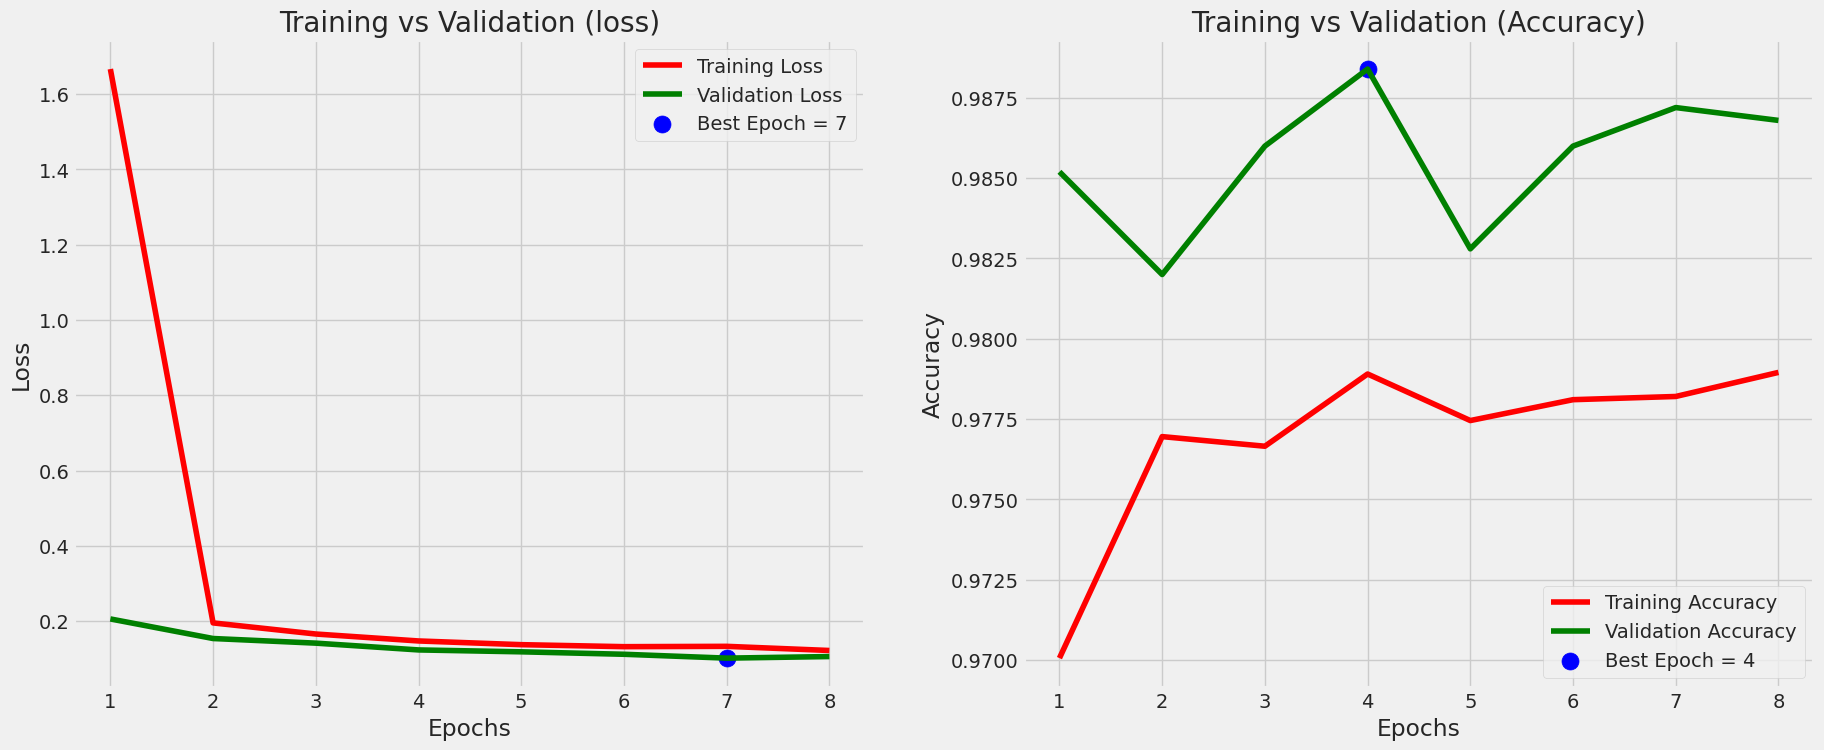

In [27]:
train_acc = history.history['accuracy']
train_loss = history.history['loss']

val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

index_loss = np.argmin(val_loss)
index_acc = np.argmax(val_acc)

val_lowest = val_loss[index_loss]
val_highest = val_acc[index_acc]

Epochs = [i+1 for i in range(len(train_acc))]

loss_label = f'Best Epoch = {str(index_loss + 1)}'
acc_label = f'Best Epoch = {str(index_acc + 1)}'

plt.figure(figsize= (20,8))
plt.style.use('fivethirtyeight')

plt.subplot(1,2,1)
plt.plot(Epochs , train_loss , 'r', label = 'Training Loss')
plt.plot(Epochs , val_loss , 'g' , label = 'Validation Loss')
plt.scatter(index_loss +1 , val_lowest , s = 150 , c = 'blue' , label = loss_label)
plt.title('Training vs Validation (loss)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(Epochs , train_acc , 'r', label= 'Training Accuracy')
plt.plot(Epochs , val_acc , 'g' , label = 'Validation Accuracy')
plt.scatter(index_acc + 1 , val_highest , s= 150 , c = 'blue' , label= acc_label)
plt.title('Training vs Validation (Accuracy)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show();

In [28]:
train_score = model.evaluate(train_gen , steps= 32 , verbose = 1)
val_score = model.evaluate(valid_gen , steps = 32 , verbose = 1)
test_score = model.evaluate(test_gen , steps = 32 , verbose = 1)

print(f'Train loss = {train_score[0] }')
print(f'Train Accuracy = {train_score[1]}')
print(f'Validation loss = {val_score[0]}')
print(f'Validation Accuracy = {val_score[1]}')
print(f'Test loss = {test_score[0]}')
print(f'Test Accuracy = {test_score[1]}')

32/32 [==============================] - 6s 196ms/step - loss: 0.0936 - accuracy: 0.9912
Train loss = 0.10708975046873093
Train Accuracy = 0.982421875
Validation loss = 0.10798592865467072
Validation Accuracy = 0.9853515625
Test loss = 0.09361179918050766
Test Accuracy = 0.9912109375


In [29]:
# Make predictions on the test set
preds = model.predict(test_gen)

# Convert the predictions to binary classes (0 or 1)
predicted_classes = (preds > 0.5).astype(int)

79/79 [==============================] - 15s 190ms/step


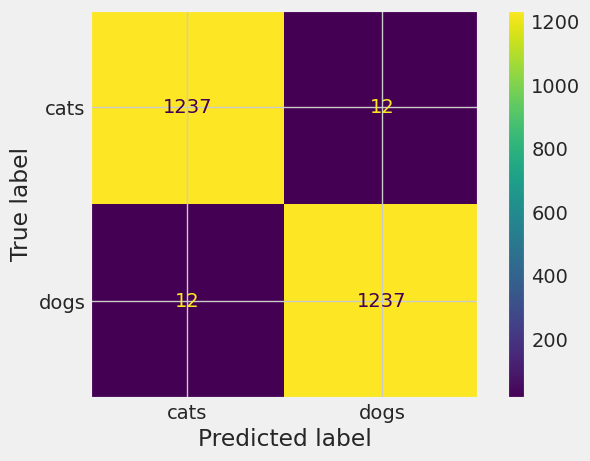

In [30]:
# Get the true labels from the generator
true_classes = test_gen.classes

# Calculate the confusion matrix
confusion = confusion_matrix(true_classes, predicted_classes)

# Display the confusion matrix as a heatmap
disp = ConfusionMatrixDisplay(confusion_matrix=confusion, display_labels=test_gen.class_indices)
disp.plot(cmap='viridis', values_format='d')

In [31]:
# Generate and print the classification report
classification_rep = classification_report(true_classes, predicted_classes, target_names=test_gen.class_indices)
print("\nClassification Report:")
print(classification_rep)


Classification Report:
              precision    recall  f1-score   support

        cats       0.99      0.99      0.99      1249
        dogs       0.99      0.99      0.99      1249

    accuracy                           0.99      2498
   macro avg       0.99      0.99      0.99      2498
weighted avg       0.99      0.99      0.99      2498

